In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 

import seaborn as sns

2023-10-07 10:54:19.516144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}


with open('mushroom_train.pkl', 'rb') as f:
    data = pickle.load(f)
    y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    X = np.array([data[i]["images"].numpy() for i in range(len(data))])

with open('mushroom_test.pkl', 'rb') as f:
    data = pickle.load(f)
    ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

## Specify learning algorithms

In [4]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [5]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        #thetas[i] = theta
        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            grad *= zeta
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = np.clip(prob_const * pz, a_min=0, a_max=1)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [6]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_new.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [7]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [8]:
# When minimizing train loss
hyperparam_per_algo

{'absloss': {'eta': 139.08692194092694, 'lam': 4.559482031366348e-05},
 'polyak_absloss': {'eta': 116.35148727967339,
  'kappa': 3.8302084646486625,
  'kappa0': 0.36611793778394397,
  'lam': 4.5555213965277435e-05,
  'omega': 1.0000003423779218},
 'polyak_exponent': {'eta': 74.398127737807,
  'kappa': 3.7666283933071116,
  'kappa0': 0.3667875801418928,
  'lam': 4.592099404449067e-05,
  'polyakexp': 0.6910929763494722},
 'random': {'eta': 91.68695928210786, 'lam': 4.551022040573563e-05}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [9]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **absloss_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6260971591786673, train loss: 0.6193100539824614, ||theta||_1: 6648.366909923347
loss: 0.5830137763673596, train loss: 0.1862227306908976, ||theta||_1: 10619.510989343475
loss: 0.5521740354970706, train loss: 0.09208804497233053, ||theta||_1: 13650.13800203348
loss: 0.5329714443976986, train loss: 0.6293679047824933, ||theta||_1: 15548.003917702834
loss: 0.515812031136699, train loss: 0.6580467474979298, ||theta||_1: 16772.9507197421
loss: 0.507057678616154, train loss: 0.5933030271357022, ||theta||_1: 17619.788777947586
loss: 0.502777161334939, train loss: 0.5670191755892189, ||theta||_1: 17983.43924604032
loss: 0.4990310132425428, train loss: 0.14590920954782102, ||theta||_1: 18218.949631331965
loss: 0.49177305858729226, train loss: 0.25795320268881955, ||theta||_1: 18566.25710440677
loss: 0.49134088679838195, train loss: 0.30094357590721266,

In [10]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [57]:
absloss_mean_sampling_prob

0.322404444395455

In [11]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6579274499886437, train loss: 0.6931085638983533, ||theta||_1: 3309.193061049473
loss: 0.6249323079025197, train loss: 0.6671975120575552, ||theta||_1: 5874.416681994543
loss: 0.6051839113501728, train loss: 0.19570083608315642, ||theta||_1: 7809.917234951347
loss: 0.5838280799350454, train loss: 0.6573518092910992, ||theta||_1: 9717.612995345147
loss: 0.5652688860226842, train loss: 0.6798806909171364, ||theta||_1: 11102.050870903608
loss: 0.5539249678929014, train loss: 0.6758396083593082, ||theta||_1: 12179.913074366204
loss: 0.5463527565187989, train loss: 0.602291674463247, ||theta||_1: 12817.053362680108
loss: 0.5369617935305655, train loss: 0.35477911050056726, ||theta||_1: 13510.061261288052
loss: 0.5308827329433969, train loss: 0.5237339576214193, ||theta||_1: 14044.449468727133
loss: 0.5261470203472149, train loss: 0.1419733970701607, 

In [12]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6490373868250289, train loss: 0.5821164463264923, ||theta||_1: 4568.732831913639
loss: 0.6104519112133798, train loss: 0.6917405993823009, ||theta||_1: 7943.657646598645
loss: 0.585432611131696, train loss: 0.08923517604110486, ||theta||_1: 10494.345000854777
loss: 0.5648484655812795, train loss: 0.1400036908389278, ||theta||_1: 12241.718919196739
loss: 0.5497814840879067, train loss: 0.616698614423601, ||theta||_1: 13541.99880025672
loss: 0.5405691378557111, train loss: 0.631823147525885, ||theta||_1: 14580.533036388193
loss: 0.529923179178046, train loss: 0.5857611597345304, ||theta||_1: 15363.163094266218
loss: 0.5213230778384307, train loss: 0.348182392944235, ||theta||_1: 15806.540790757263
loss: 0.5158711732592665, train loss: 0.6370138689168133, ||theta||_1: 16202.082925176037
loss: 0.5162445986424183, train loss: 0.5630572277001126, ||th

In [13]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6453010700767677, train loss: 0.6666614246897103, ||theta||_1: 4460.397302934143
loss: 0.6068275454660927, train loss: 0.6445290464850804, ||theta||_1: 7812.980936134489
loss: 0.5812347925127405, train loss: 0.6217639941870163, ||theta||_1: 10191.978685632397
loss: 0.5599033619120961, train loss: 0.23466882424379173, ||theta||_1: 12078.977038324929
loss: 0.538388546275299, train loss: 0.6480467210955908, ||theta||_1: 13516.26968153463
loss: 0.5256714285677927, train loss: 0.2160537161739597, ||theta||_1: 14622.321283181484
loss: 0.518287630161366, train loss: 0.6254664072023005, ||theta||_1: 15556.413600332866
loss: 0.5100277603096794, train loss: 0.18504292012863538, ||theta||_1: 16179.606038035838
loss: 0.5043330622783602, train loss: 0.32795353315371095, ||theta||_1: 16661.90419857228
loss: 0.5005342822316763, train loss: 0.38991459459844635

In [14]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

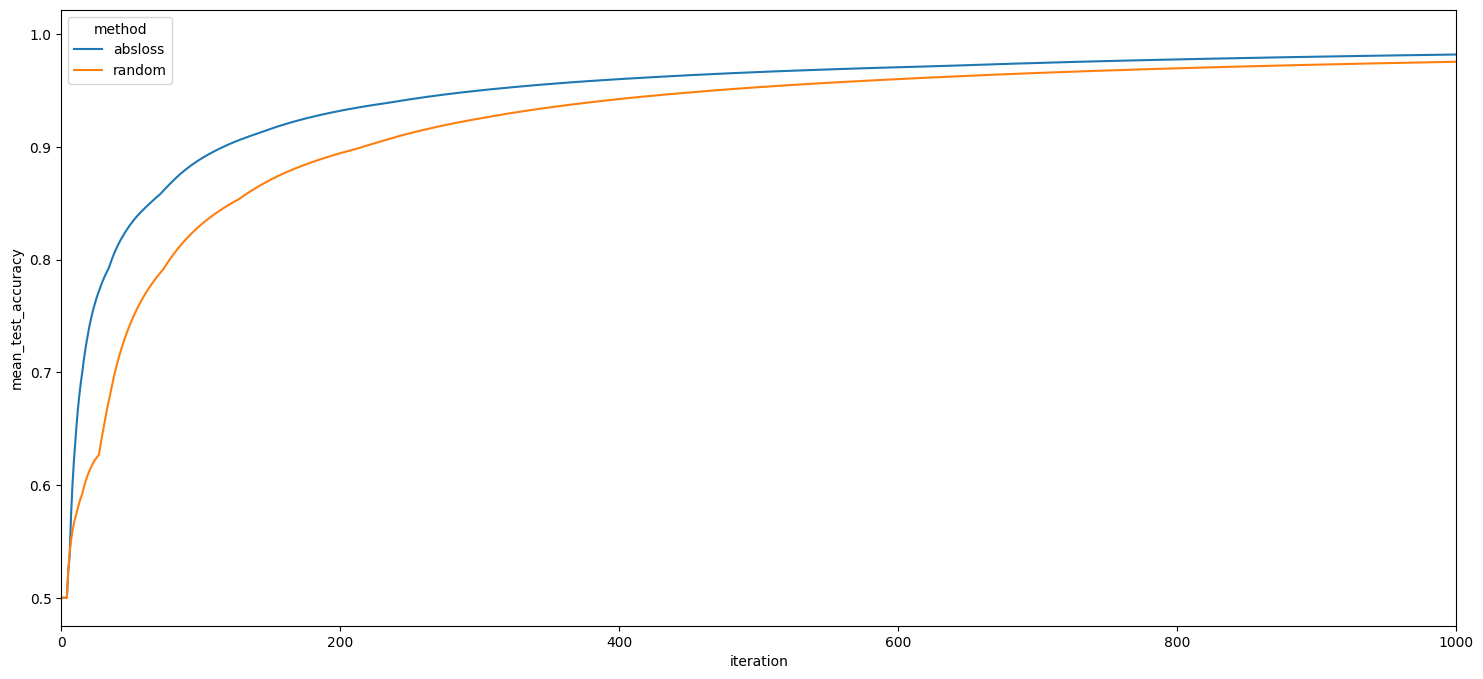

In [15]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

(0.0, 1000.0)

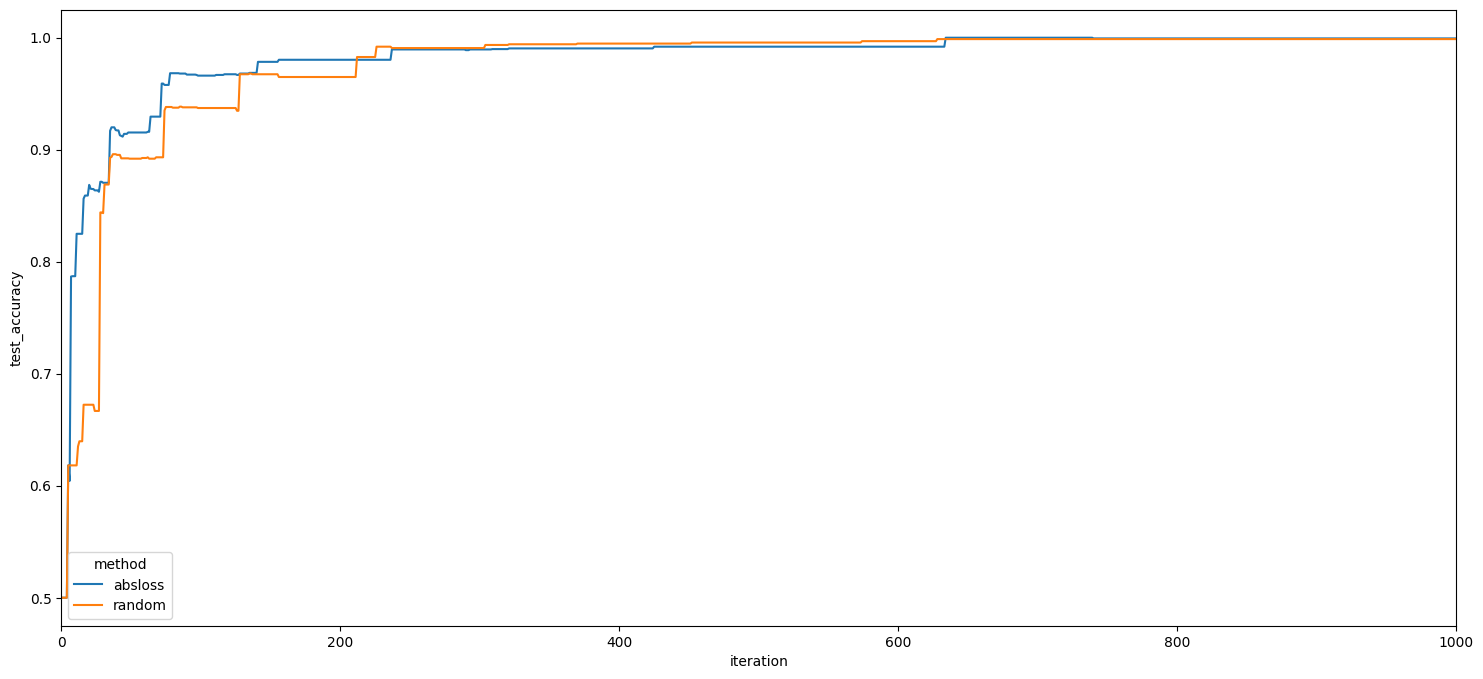

In [16]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

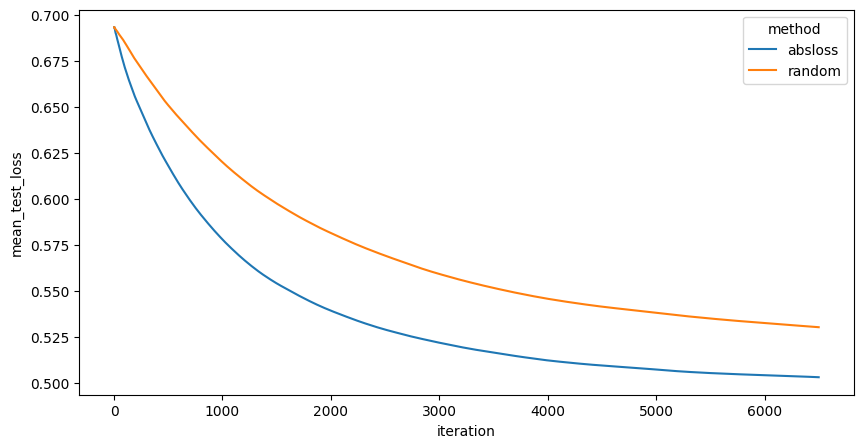

In [17]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

Text(0, 0.5, 'average cross entropy loss')

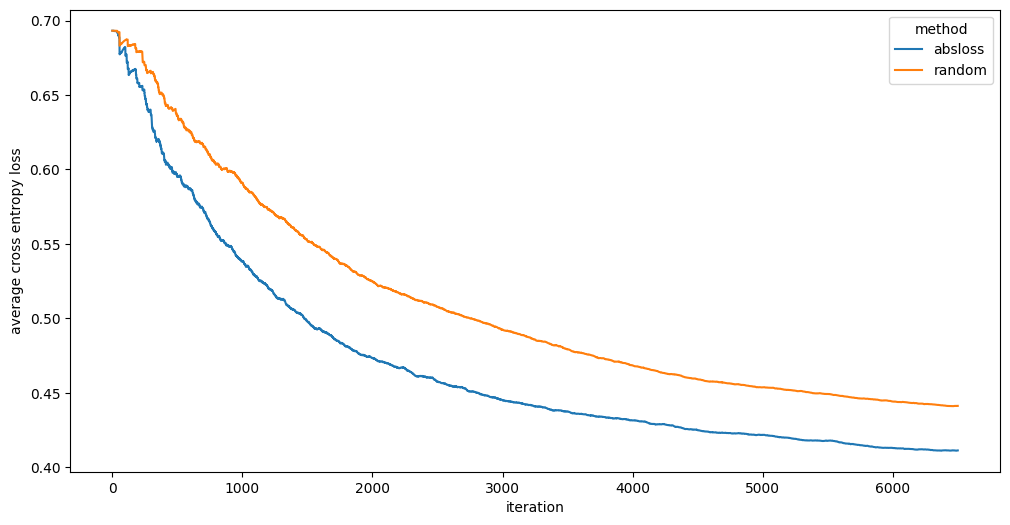

In [18]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

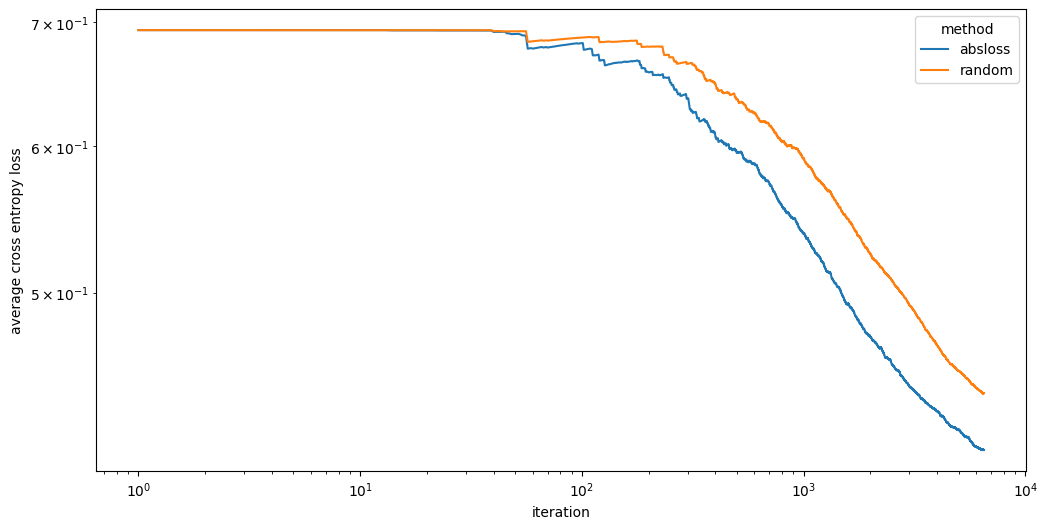

In [19]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [20]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 6499 iterations with d=6499
loss: 0.692490217996702, train loss: 0.6931471805599453, ||theta||_1: 43.15946834182385
loss: 0.659418625358694, train loss: 0.6705805385959505, ||theta||_1: 3212.189414223845
loss: 0.6307396481054484, train loss: 0.6900322905695901, ||theta||_1: 5514.162421229661
loss: 0.6080679480962059, train loss: 0.2463943912110279, ||theta||_1: 7345.281126114595
loss: 0.5869176397827747, train loss: 0.6844750278106105, ||theta||_1: 8837.747879646979
loss: 0.5675276114436619, train loss: 0.67996018960068, ||theta||_1: 10422.450326336866
loss: 0.5560926146424819, train loss: 0.6712991843661272, ||theta||_1: 11361.507175880666
loss: 0.5478754153507314, train loss: 0.27559685308757625, ||theta||_1: 12239.24435499035
loss: 0.5399822641095654, train loss: 0.2228801017680014, ||theta||_1: 13008.007773428892
loss: 0.5316064953853762, train loss: 0.28608576569314204, ||theta||_1: 13593.428804920888
loss: 0.5259617472822867, train loss: 0

In [55]:
0.6910929763494722

0.6910929763494722

In [54]:
math.log(0.5) / math.log(0.36)

0.6784577244283619

In [21]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.001, 0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[6.887283522943917,
 4.591522348629278,
 2.295761174314639,
 1.3821859526989444,
 0.6910929763494722]

In [22]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [23]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [24]:
empirical_pzs

[0.000999999999999999,
 0.009999999999999993,
 0.09999999999999995,
 0.24999999999999997,
 0.49999999999999994]

In [25]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [26]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [41]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs
polyak_exponent  0.7         0.500    0.468736
                 1.4         0.250    0.419178
                 2.3         0.100    0.435525
                 4.6         0.010    0.570794
                 6.9         0.001    0.688010
random           0.7         0.500    0.426322
                 1.4         0.250    0.456380
                 2.3         0.100    0.525225
                 4.6         0.010    0.669582
                 6.9         0.001    0.691450
Name: train_loss, dtype: float64

In [28]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs
polyak_exponent  0.7         0.500    0.468425
                 1.4         0.250    0.419071
                 2.3         0.100    0.435520
                 4.6         0.010    0.570794
                 6.9         0.001    0.687973
random           0.7         0.500    0.426078
                 1.4         0.250    0.456144
                 2.3         0.100    0.525159
                 4.6         0.010    0.669521
                 6.9         0.001    0.691427
Name: mean_train_loss, dtype: float64

Polyak exp value 6.9 has rows (12998, 16)
Polyak exp value 4.6 has rows (12998, 16)
Polyak exp value 2.3 has rows (12998, 16)
Polyak exp value 1.4 has rows (12998, 16)
Polyak exp value 0.7 has rows (12998, 16)


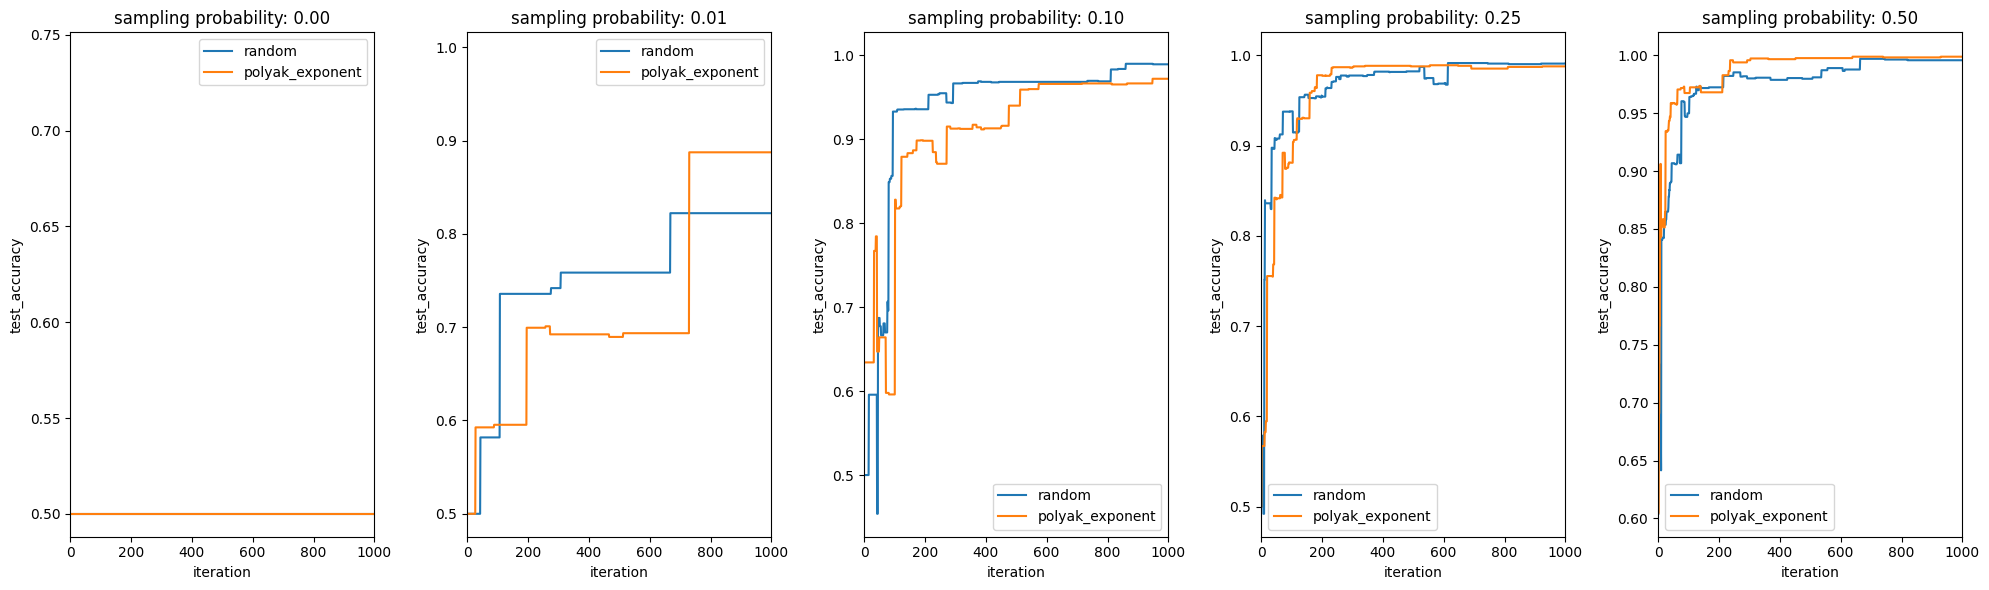

In [29]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 6.9 has rows (12998, 16)
Polyak exp value 4.6 has rows (12998, 16)
Polyak exp value 2.3 has rows (12998, 16)
Polyak exp value 1.4 has rows (12998, 16)
Polyak exp value 0.7 has rows (12998, 16)


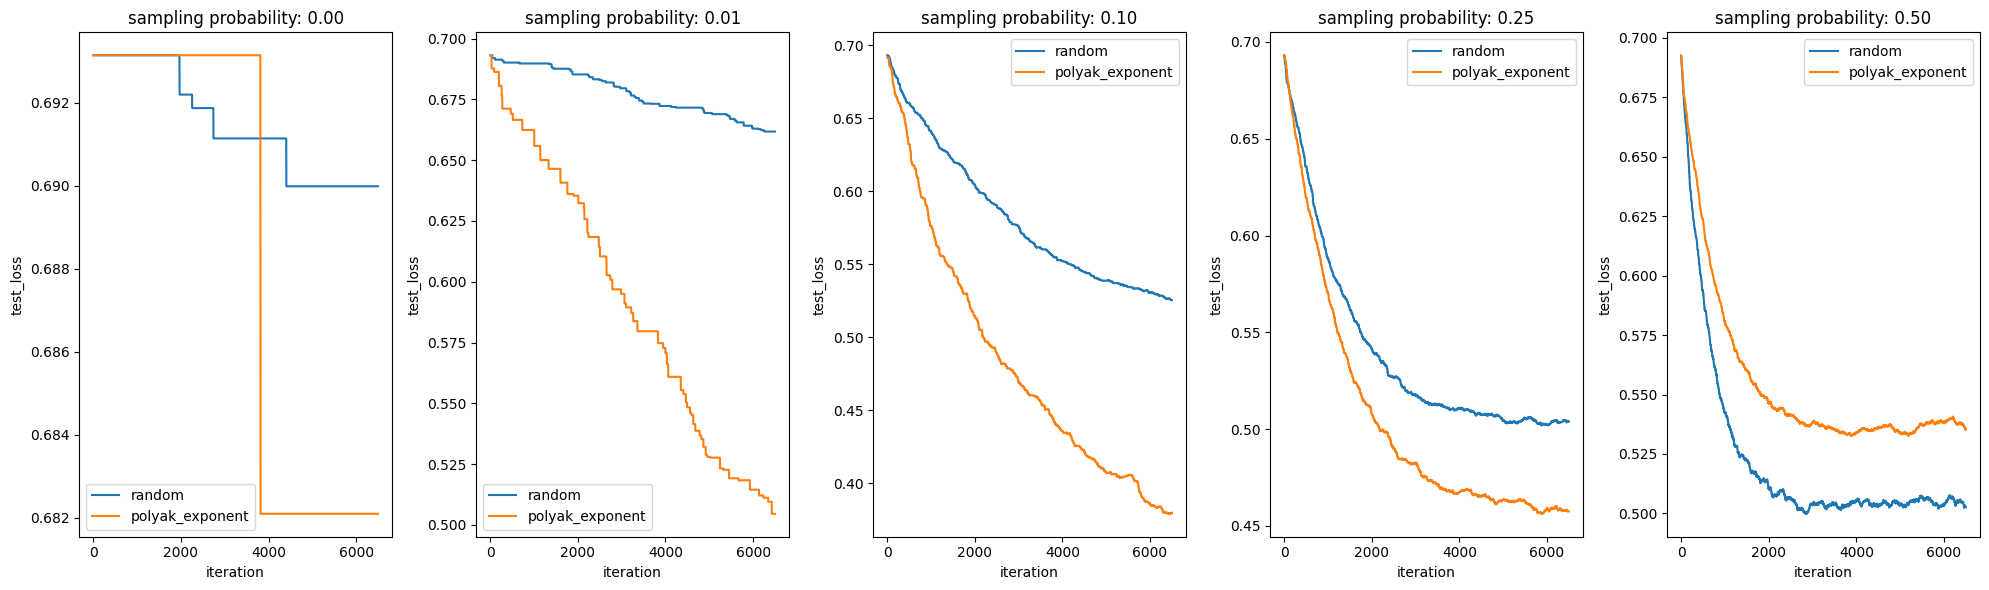

In [30]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

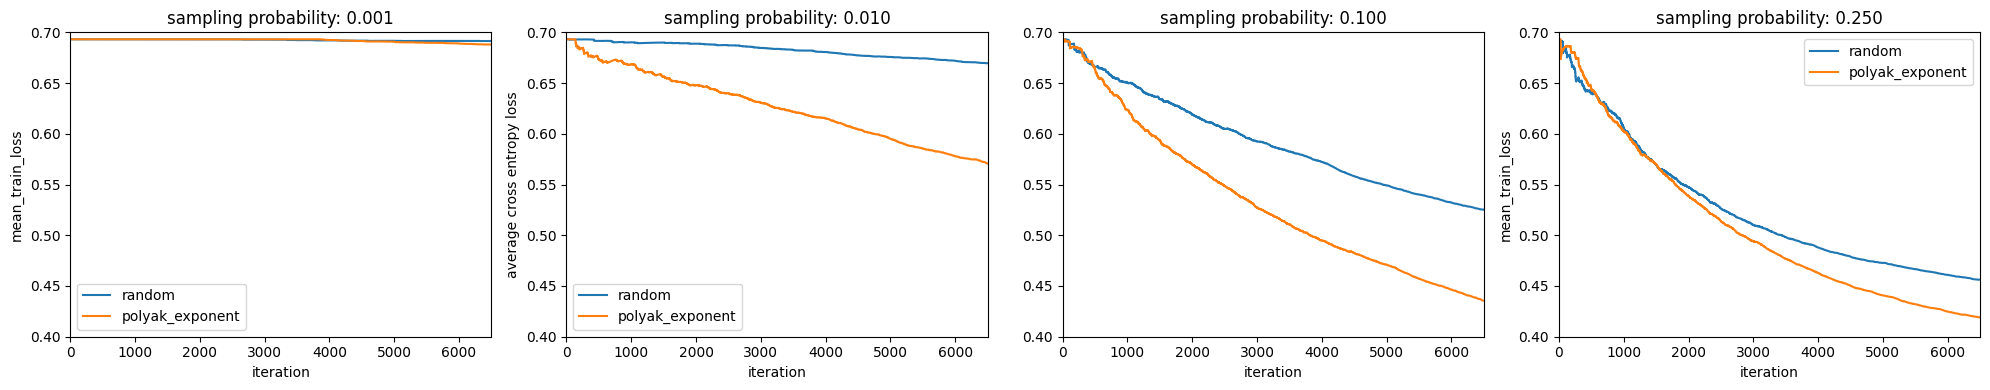

In [31]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    if pz > 0.26:
        continue
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.40, 0.7))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[1].set_ylabel("average cross entropy loss")
axs[2].set_ylabel("")

axs[2].get_legend().remove()

f.tight_layout()

0.000999999999999999
Polyak exp value 6.9 has rows (12998, 16)
0.009999999999999993
Polyak exp value 4.6 has rows (12998, 16)
0.09999999999999995
Polyak exp value 2.3 has rows (12998, 16)
0.24999999999999997
Polyak exp value 1.4 has rows (12998, 16)
0.49999999999999994
Polyak exp value 0.7 has rows (12998, 16)


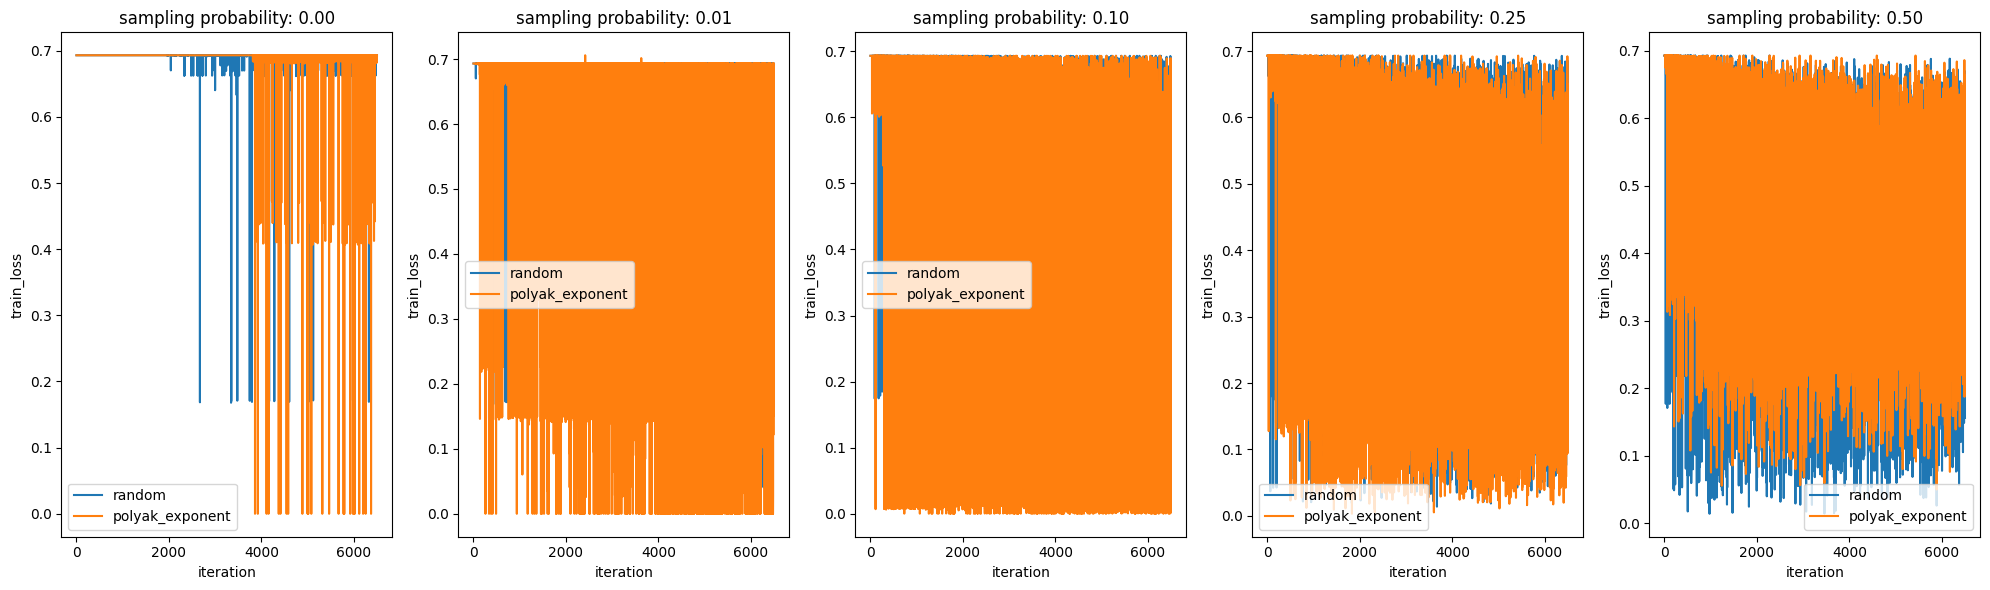

In [32]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.000999999999999999
Polyak exp value 6.9 has rows (12998, 16)
0.009999999999999993
Polyak exp value 4.6 has rows (12998, 16)
0.09999999999999995
Polyak exp value 2.3 has rows (12998, 16)
0.24999999999999997
Polyak exp value 1.4 has rows (12998, 16)
0.49999999999999994
Polyak exp value 0.7 has rows (12998, 16)


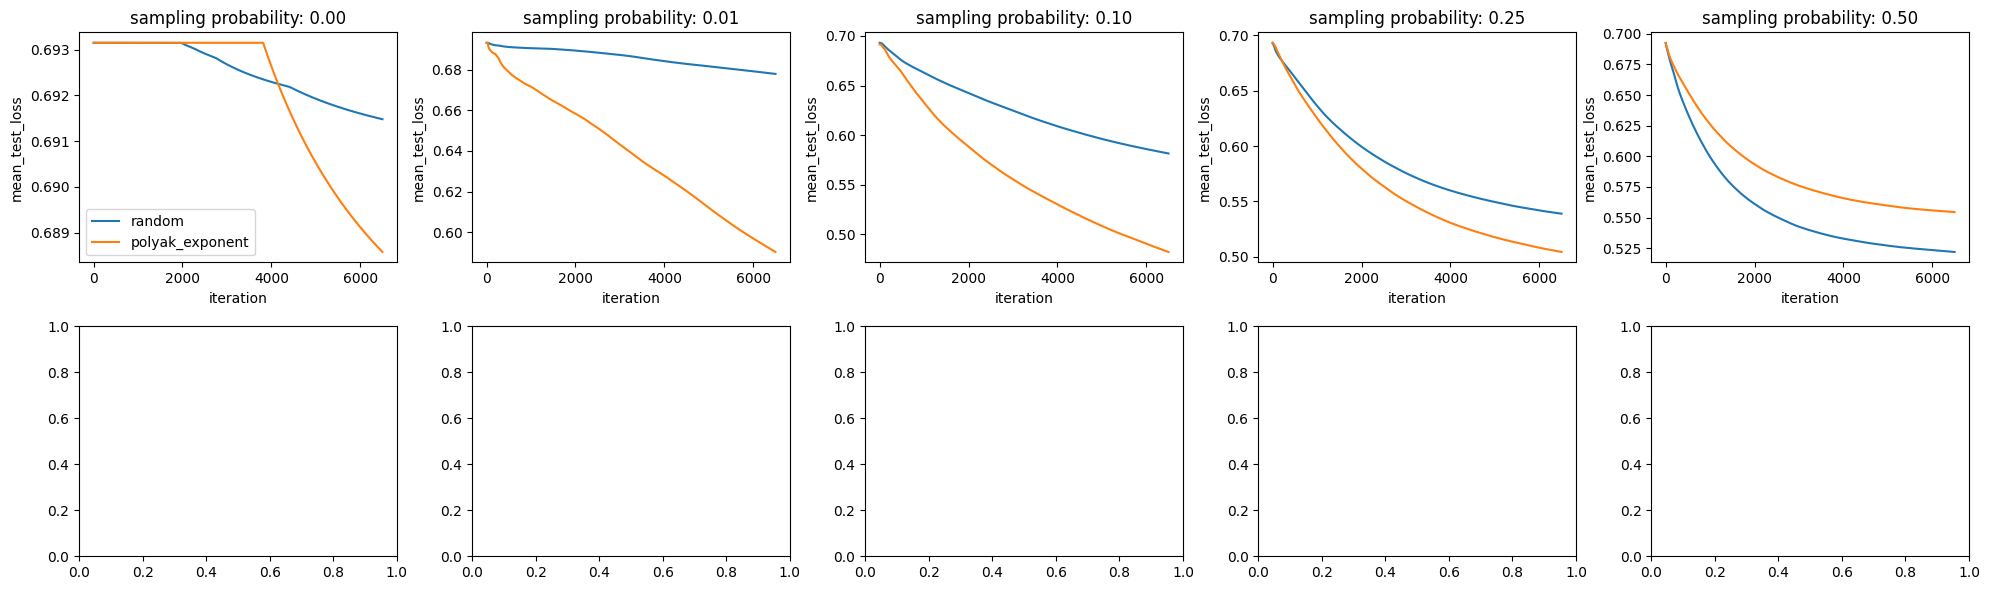

In [33]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [34]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, **(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
)

Training with algorithm polyak_absloss: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6458690105794871, train loss: 0.6930853690948482, ||theta||_1: 4205.637444494027
loss: 0.6109948221970756, train loss: 0.2908144345954071, ||theta||_1: 7225.682531045619
loss: 0.5879836414530855, train loss: 0.6693396575080263, ||theta||_1: 9507.787549841456
loss: 0.5641518299903131, train loss: 0.25704191825293515, ||theta||_1: 11458.233838357386
loss: 0.5460615104952008, train loss: 0.6518692476438862, ||theta||_1: 12850.182620616999
loss: 0.5327869626211709, train loss: 0.6364440739279269, ||theta||_1: 13999.076950909017
loss: 0.5267117877290216, train loss: 0.6058674253513167, ||theta||_1: 14818.196569945705
loss: 0.5195687420251168, train loss: 0.5818408980546755, ||theta||_1: 15472.430685336345
loss: 0.5125562923790827, train loss: 0.5196496168537804, ||theta||_1: 16030.887343131892
loss: 0.5083403373396878, train loss: 0.169210825

In [35]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

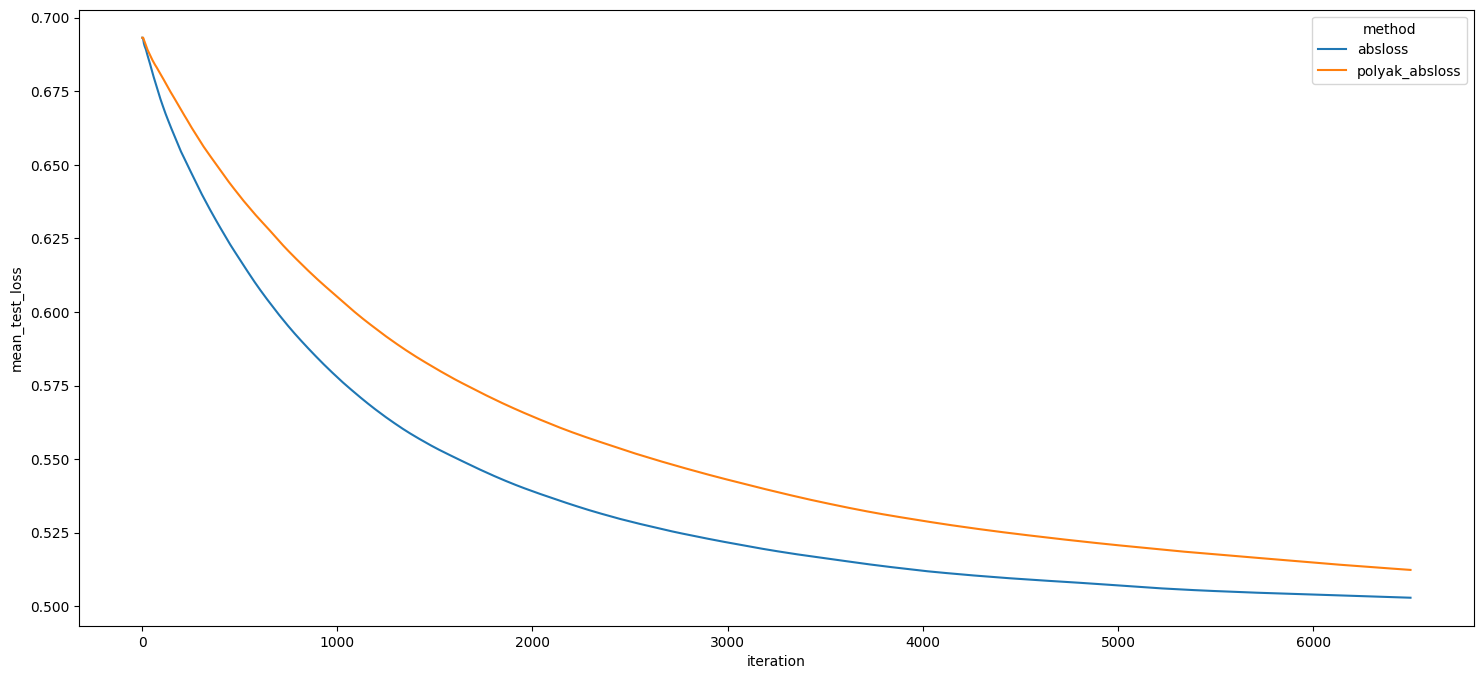

In [36]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

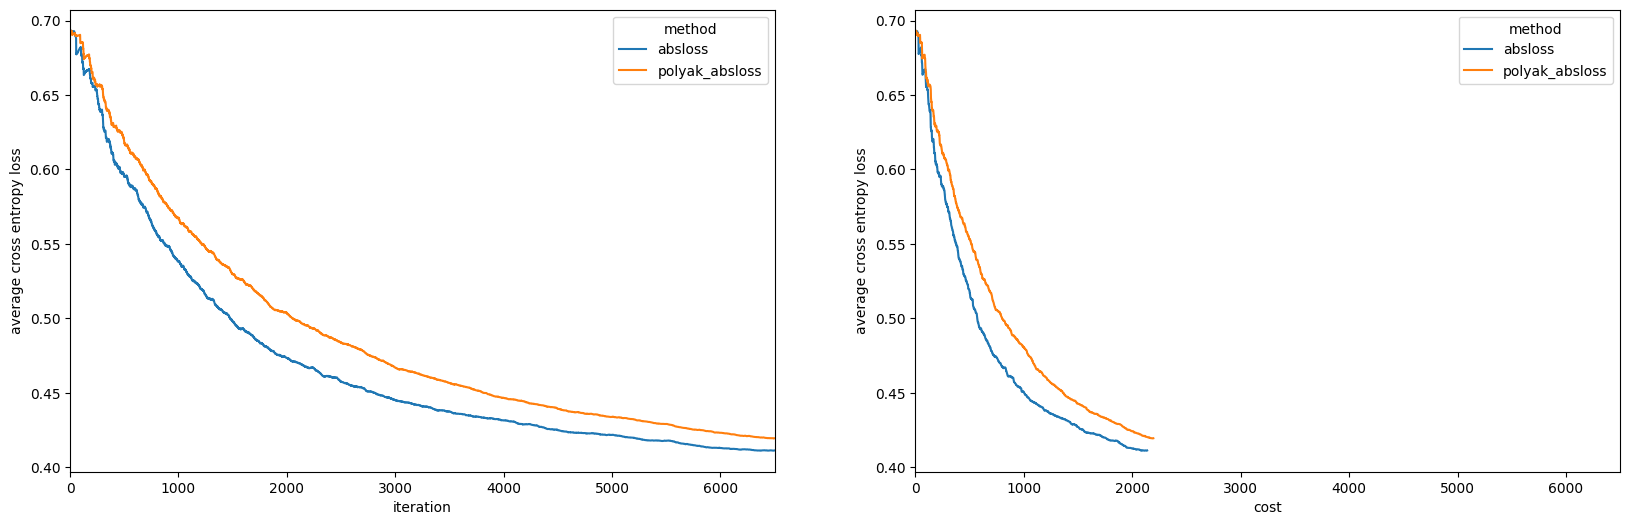

In [37]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

<Axes: xlabel='iteration', ylabel='mean_test_accuracy'>

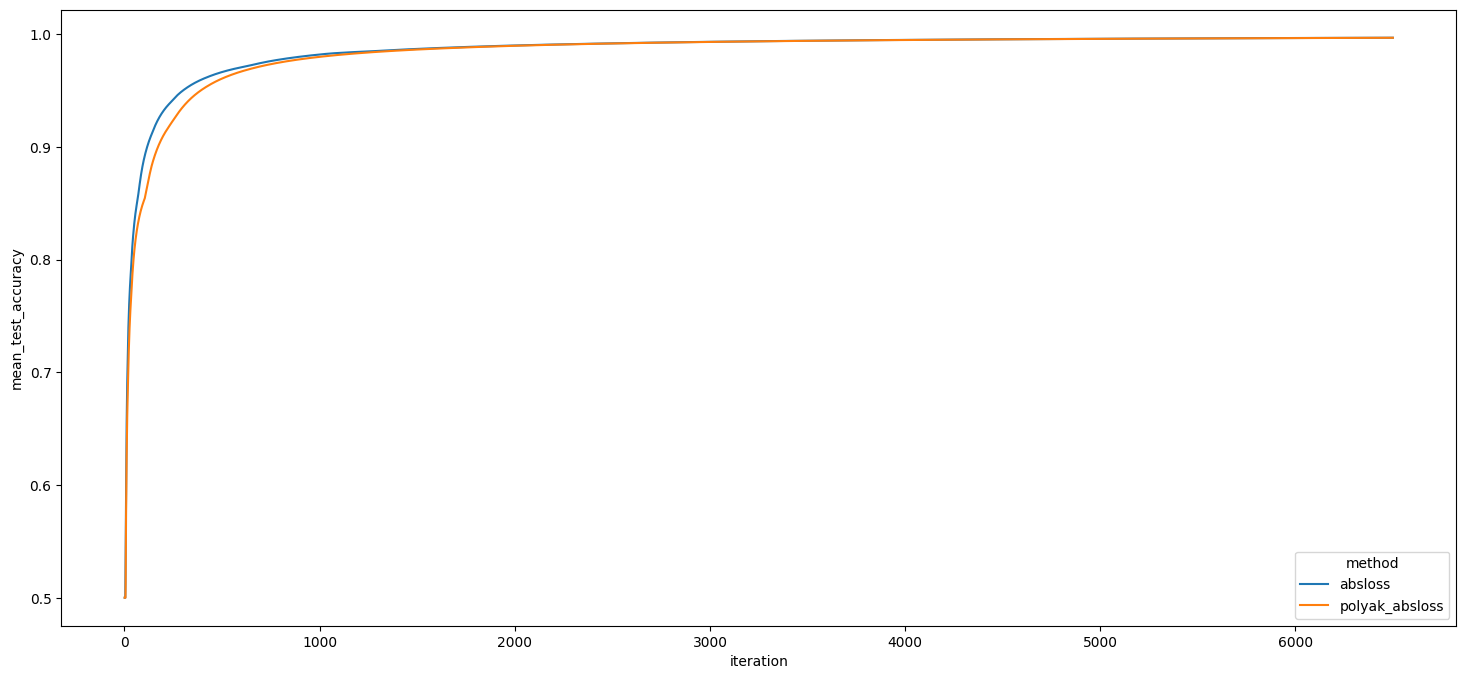

In [38]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

In [39]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

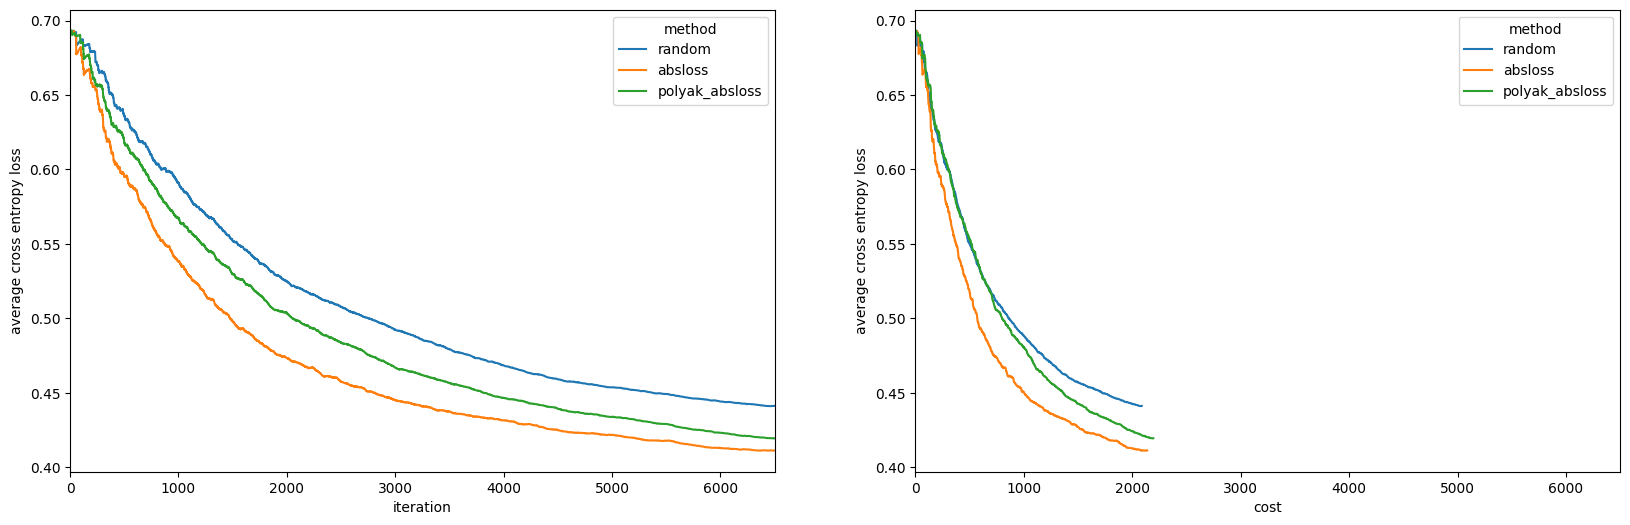

In [40]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))